In [1]:
import tensorflow as tf
from math import pi,e
from matplotlib import pyplot as plt
from IPython.display import HTML

In [2]:
@tf.function
def f(X):
    m = 10
    dtype = X.dtype
    C = tf.constant([[4.0, 4.0], [1.0, 1.0], [8.0, 8.0], [6.0, 6.0], [3.0, 7.0], [2.0, 9.0], [5.0, 5.0], [8.0, 1.0], [6.0, 2.0], [7.0, 3.6]], dtype=dtype)
    beta = tf.constant([0.1, 0.2, 0.2, 0.4, 0.4, 0.6, 0.3, 0.7, 0.5, 0.5], dtype=dtype)
    result = tf.constant(0.0, dtype=dtype)
    for i in range(m):
        result += 1.0 / (beta[i] + tf.reduce_sum(tf.square(X - C[i]), axis=1))
    return -result

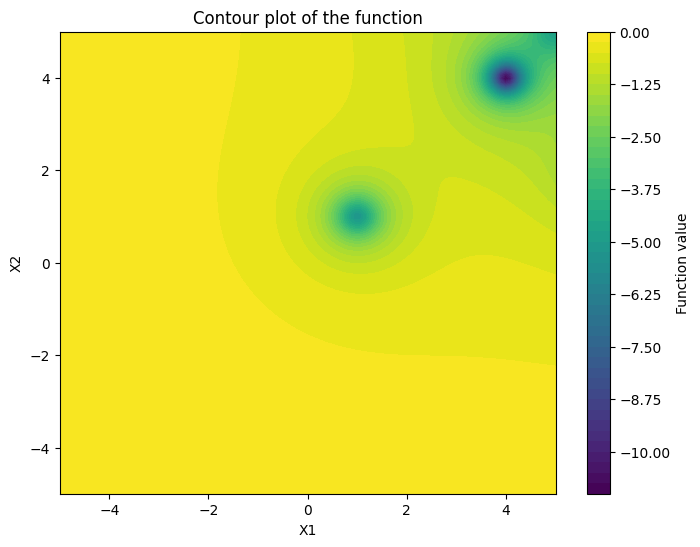

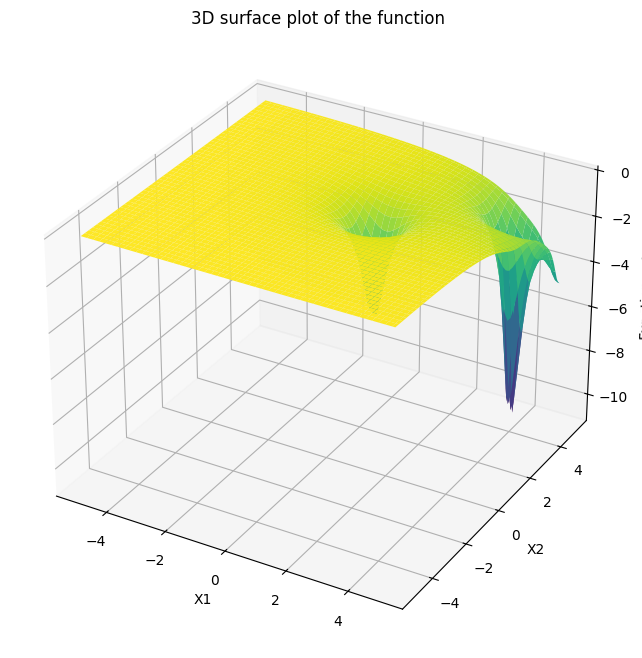

In [3]:
# Making lims
lim = 5

# Create a meshgrid for plotting
X1, X2 = tf.meshgrid(tf.linspace(-lim, lim, 100), tf.linspace(-lim, lim, 100))
X_grid = tf.stack([tf.reshape(X1, [-1]), tf.reshape(X2, [-1])], axis=1)
Y_grid = f(X_grid)
Y_grid = tf.reshape(Y_grid, X1.shape)

# Plot the contour
plt.figure(figsize=(8, 6))
plt.contourf(X1, X2, Y_grid, levels=50, cmap='viridis')
plt.colorbar(label='Function value')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Contour plot of the function')
plt.show()

# Plot the 3D surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, Y_grid, cmap='viridis')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Function value')
ax.set_title('3D surface plot of the function')
plt.show()


1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28 28
29 29
30 30
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28 28
29 29
30 30


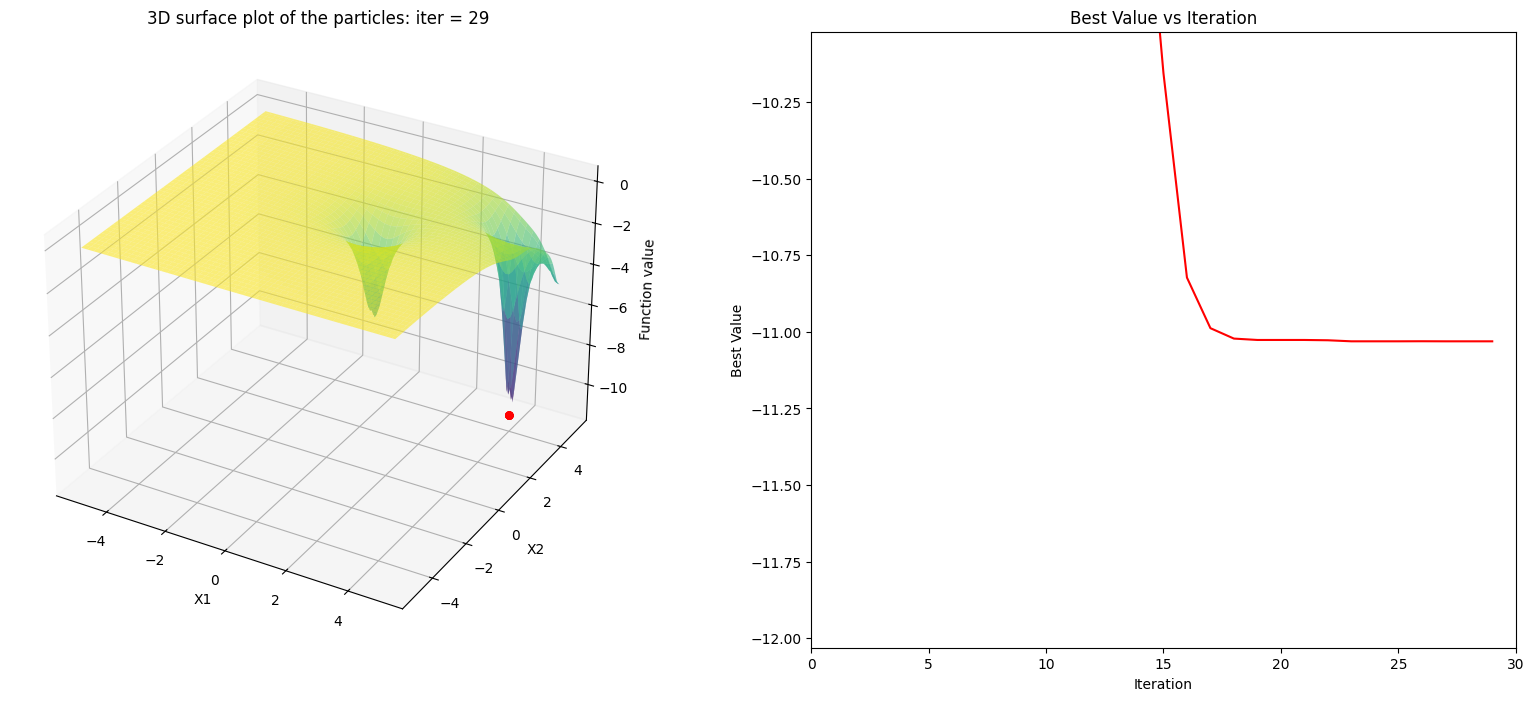

In [4]:
from matplotlib.animation import FuncAnimation

# Setting up the particles
n_particles = 20
current_position = tf.random.uniform((n_particles, 2), -lim, lim)
rand_vector = tf.random.uniform((n_particles, 2), minval=-1, maxval=2, dtype=tf.int32)
rand_vector = tf.where(rand_vector == 2, 0, rand_vector)  # Ensure values are -1, 0, or 1
rand_vector = tf.tensor_scatter_nd_update(rand_vector, [[tf.random.uniform([], 0, n_particles, dtype=tf.int32), tf.random.uniform([], 0, 2, dtype=tf.int32)]], [0])
rand_vector = tf.cast(rand_vector, tf.float32) * lim
current_position += rand_vector
current_position = tf.clip_by_value(current_position, -lim, lim)
best_values = []

best_position           = tf.Variable(current_position)
current_value           = tf.Variable(f(current_position))
best_value              = tf.Variable(current_value)
current_velocity        = tf.random.uniform((n_particles, 2), -0.1, 0.1)
global_best_value       = tf.Variable(tf.reduce_min(best_value))
global_best_position    = tf.Variable(best_position[tf.argmin(best_value)])
iniertia_weight         = tf.Variable(0.95)
global_accel            = tf.constant(0.5)
personal_accel          = tf.constant(1)


def particle_swarm(current_position, current_value, best_position, best_value, current_velocity, iniertia_weight, global_accel, personal_accel, global_best_position, lim):
    new_velocity = 0
    new_velocity += iniertia_weight * current_velocity
    new_velocity += personal_accel * tf.random.uniform((n_particles, 2)) * (best_position - current_position)
    new_velocity += global_accel * tf.random.uniform((n_particles, 2)) * (global_best_position - current_position)
    
    new_position = current_position + new_velocity
    new_position = tf.clip_by_value(new_position, -lim, lim)
    new_value = f(new_position)
    
    best_position = tf.where(tf.expand_dims(new_value < current_value, axis=1), new_position, best_position)
    best_value = tf.where(new_value < current_value, new_value, best_value)
    
    global_best_position = tf.where(tf.reduce_min(new_value) < global_best_value, new_position[tf.argmin(new_value)], global_best_position)
    global_best_value.assign(tf.reduce_min(best_value))
    return new_position, best_position, new_value, best_value, new_velocity, global_best_position,global_best_value

ax3d = fig.add_subplot(121, projection='3d')
fig, (ax3d, ax2d) = plt.subplots(1, 2, figsize=(20, 8), subplot_kw={'projection': '3d' if ax3d else None})
ax2d = fig.add_subplot(122)


def init():
    ax3d.plot_surface(X1, X2, Y_grid, cmap='viridis', alpha=0.6)
    scat = ax3d.scatter(current_position[:, 0], current_position[:, 1], current_value, color='blue')
    ax2d.set_xlim(0, 30)
    ax2d.set_ylim(tf.reduce_min(best_value).numpy() - 1, tf.reduce_max(best_value).numpy() + 1)
    line, = ax2d.plot([], [], 'r-')
    return scat, line

def update(frame):
    global current_position, best_position, current_value, best_value, current_velocity, global_best_position,best_values
    iniertia_weight         = tf.Variable(0.5)
    global_accel            = tf.constant(0.25)
    personal_accel          = tf.constant(0.25)

    if frame == 0:
        best_values = []
        current_position = tf.random.uniform((n_particles, 2), -lim, lim)
        rand_vector = tf.random.uniform((n_particles, 2), minval=-1, maxval=2, dtype=tf.int32)
        rand_vector = tf.where(rand_vector == 2, 0, rand_vector)  # Ensure values are -1, 0, or 1
        rand_vector = tf.tensor_scatter_nd_update(rand_vector, [[tf.random.uniform([], 0, n_particles, dtype=tf.int32), tf.random.uniform([], 0, 2, dtype=tf.int32)]], [0])
        rand_vector = tf.cast(rand_vector, tf.float32) * lim
        current_position += rand_vector
        current_position = tf.clip_by_value(current_position, -lim, lim)
        best_position           = tf.Variable(current_position)
        current_value           = tf.Variable(f(current_position))
        best_value              = tf.Variable(current_value)
        current_velocity        = tf.random.uniform((n_particles, 2), -0.1, 0.1)
        global_best_position    = tf.Variable(best_position[tf.argmin(best_value)])
        color = 'blue'
    else:
        color = 'red'

    ax3d.clear()
    ax3d.plot_surface(X1, X2, Y_grid, cmap='viridis', alpha=0.6)
    scat = ax3d.scatter(current_position[:, 0], current_position[:, 1], current_value, color=color, s=25)
    ax3d.set_xlabel('X1')
    ax3d.set_ylabel('X2')
    ax3d.set_zlabel('Function value')
    ax3d.set_title(f'3D surface plot of the particles: iter = {frame}')

    current_position, best_position, current_value, best_value, current_velocity, global_best_position,global_best_value = particle_swarm(
        current_position, current_value, best_position, best_value, current_velocity, iniertia_weight, global_accel, personal_accel, global_best_position, lim
    )

    best_values.append(tf.reduce_min(best_value).numpy())
    ax2d.clear()
    ax2d.plot(range(frame + 1), best_values, 'r-')
    ax2d.set_xlim(0, 30)
    ax2d.set_ylim(tf.reduce_min(best_value).numpy() - 1, tf.reduce_max(best_value).numpy() + 1)
    ax2d.set_xlabel('Iteration')
    ax2d.set_ylabel('Best Value')
    ax2d.set_title('Best Value vs Iteration')

    return scat,

ani = FuncAnimation(fig, update, frames=30, init_func=init, blit=True, repeat=False)
HTML(ani.to_jshtml())
ani.save('animation.gif', writer='pillow')



In [ ]:
#ani.save('animation.gif', writer='pillow')